# ShopTalk EDA – Data Ingestion & Exploratory Data Analysis

**Project:** ShopTalk – AI-Powered Shopping Assistant  
**Dataset:** [Amazon Berkeley Objects (ABO)](https://amazon-berkeley-objects.s3.amazonaws.com/index.html)  
**Author:** Balaji Gurusala  
**Notebook Scope:** T000a / T000b from `.spec/tasks.md`

---

### ABO Dataset Overview

The Amazon Berkeley Objects (ABO) dataset is a large-scale collection of product listings enriched with multi-modal metadata. The most useful features for ShopTalk are:

| Feature | Description |
|---------|-------------|
| **item_id** | Unique product identifier |
| **item_name** / **item_name_in_english** | Product title (multilingual, with English translation) |
| **product_description** | Free-text product description |
| **bullet_point** | Key feature bullet points |
| **brand** | Brand / manufacturer name |
| **color** | Product color(s) |
| **product_type** | Product category / type hierarchy |
| **item_keywords** | Seller-provided search keywords |
| **main_image_id** / **other_image_id** | References to product images |
| **item_weight** / **item_dimensions** | Physical attributes |
| **country** | Market / locale of the listing |

---

### Notebook Outline

1. **Step 1 – Data Ingestion:** Download & extract ABO listings + thumbnails from S3.  
2. **Step 2 – Data Loading:** Parse metadata JSON into a DataFrame.  
3. **Step 3 – Data Cleaning:** Missing values, duplicates, outliers.  
4. **Step 4 – NLP Feature Engineering:** Title length, description word count, distributions.  
5. **Step 5 – Visual Analysis:** Top brands, word clouds, n-gram analysis.  
6. **Step 6 – Image Verification:** Display sample product images to verify linkage.  
7. **Summary & Next Steps**

---

## Step 0 – Environment Setup & Imports

In [3]:
# ============================================================
# Step 0: Environment Setup & Imports
# ============================================================

import os
import sys
import json
import gzip
import glob
import tarfile
import warnings
from pathlib import Path
from collections import Counter

import boto3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from tqdm.notebook import tqdm

# NLP
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

# Image display
from IPython.display import display, Image as IPImage, HTML

# Settings
warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid', palette='muted', font_scale=1.1)
plt.rcParams['figure.dpi'] = 120
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 120)

# NLTK downloads (run once)
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)

print(f"Python {sys.version}")
print(f"Pandas {pd.__version__} | NumPy {np.__version__}")
print("Environment ready.")

Python 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Pandas 2.2.2 | NumPy 2.0.2
Environment ready.


---

## Step 1 – Automatic Data Ingestion from S3

We download **two archives** from the public ABO S3 bucket:

| Archive | Contents | Approx. Size |
|---------|----------|--------------|
| `abo-listings.tar` | Product metadata (JSON lines, gzipped) | ~350 MB |
| `abo-images-small.tar` | Thumbnail images (256 px) | ~1.2 GB |

The script:
- Uses **unsigned** boto3 access (public bucket, no credentials needed).  
- Skips download/extraction if files already exist (“resume-safe”).  
- Shows a `tqdm` progress bar for each download.

In [4]:
# ============================================================
# Step 1: Automatic Data Ingestion from S3
# ============================================================

from botocore import UNSIGNED
from botocore.config import Config

# ---------- Configuration ----------
DATA_DIR = Path("./data")
DATA_DIR.mkdir(parents=True, exist_ok=True)

BUCKET = "amazon-berkeley-objects"
ARCHIVES = {
    "abo-listings.tar": "archives/abo-listings.tar",
    "abo-images-small.tar": "archives/abo-images-small.tar",
}

# Unsigned (anonymous) S3 client
s3 = boto3.client("s3", config=Config(signature_version=UNSIGNED))


def download_from_s3(key: str, local_path: Path) -> None:
    """Download an S3 object with a tqdm progress bar.

    Args:
        key: S3 object key.
        local_path: Local file path to save to.
    """
    meta = s3.head_object(Bucket=BUCKET, Key=key)
    total_bytes = meta["ContentLength"]

    with tqdm(total=total_bytes, unit="B", unit_scale=True,
              desc=local_path.name) as pbar:
        s3.download_file(
            BUCKET, key, str(local_path),
            Callback=lambda bytes_transferred: pbar.update(bytes_transferred),
        )


def extract_tar(tar_path: Path, dest: Path) -> None:
    """Extract a tar archive to dest with progress.

    Args:
        tar_path: Path to the .tar file.
        dest: Directory to extract into.
    """
    with tarfile.open(tar_path) as tf:
        members = tf.getmembers()
        for member in tqdm(members, desc=f"Extracting {tar_path.name}"):
            tf.extract(member, path=dest)


# ---------- Download & Extract ----------
for filename, s3_key in ARCHIVES.items():
    local_tar = DATA_DIR / filename
    # Determine extraction marker (first directory inside tar)
    extract_marker = DATA_DIR / filename.replace(".tar", "").replace("abo-", "")

    # Download
    if local_tar.exists():
        print(f"\u2713 {filename} already downloaded, skipping.")
    else:
        print(f"\u2193 Downloading {filename} ...")
        download_from_s3(s3_key, local_tar)
        print(f"\u2713 {filename} downloaded.")

    # Extract
    if extract_marker.exists():
        print(f"\u2713 {filename} already extracted, skipping.")
    else:
        print(f"\U0001f4e6 Extracting {filename} ...")
        extract_tar(local_tar, DATA_DIR)
        print(f"\u2713 {filename} extracted.")

print("\n\u2705 Data ingestion complete.")
print("Contents of data/:")
for p in sorted(DATA_DIR.iterdir()):
    print(f"  {p.name}{'/' if p.is_dir() else ''}")

✓ abo-listings.tar already downloaded, skipping.
✓ abo-listings.tar already extracted, skipping.
✓ abo-images-small.tar already downloaded, skipping.
📦 Extracting abo-images-small.tar ...


Extracting abo-images-small.tar:   0%|          | 0/398474 [00:00<?, ?it/s]

✓ abo-images-small.tar extracted.

✅ Data ingestion complete.
Contents of data/:
  LICENSE-CC-BY-4.0.txt
  abo-images-small.tar
  abo-listings.tar
  images/
  listings/


---

## Step 2 – Data Loading

The ABO listings metadata is stored as **JSON Lines** (one JSON object per line) inside a gzipped file.  
We locate it automatically and load into a Pandas DataFrame.

In [5]:
# ============================================================
# Step 2: Data Loading
# ============================================================

# --- Locate the metadata file ---
json_gz_files = sorted(DATA_DIR.rglob("*.json.gz"))
print(f"Found {len(json_gz_files)} JSON-GZ file(s):")
for f in json_gz_files:
    print(f"  {f}")

# Pick the listings metadata (usually the largest / first match under listings/metadata/)
metadata_path = None
for f in json_gz_files:
    if "listings" in str(f) and "metadata" in str(f):
        metadata_path = f
        break

if metadata_path is None:
    # Fallback: just take the first json.gz
    metadata_path = json_gz_files[0] if json_gz_files else None

assert metadata_path is not None, (
    "No metadata JSON file found. Check extraction in Step 1."
)
print(f"\nLoading metadata from: {metadata_path}")

Found 16 JSON-GZ file(s):
  data/listings/metadata/listings_0.json.gz
  data/listings/metadata/listings_1.json.gz
  data/listings/metadata/listings_2.json.gz
  data/listings/metadata/listings_3.json.gz
  data/listings/metadata/listings_4.json.gz
  data/listings/metadata/listings_5.json.gz
  data/listings/metadata/listings_6.json.gz
  data/listings/metadata/listings_7.json.gz
  data/listings/metadata/listings_8.json.gz
  data/listings/metadata/listings_9.json.gz
  data/listings/metadata/listings_a.json.gz
  data/listings/metadata/listings_b.json.gz
  data/listings/metadata/listings_c.json.gz
  data/listings/metadata/listings_d.json.gz
  data/listings/metadata/listings_e.json.gz
  data/listings/metadata/listings_f.json.gz

Loading metadata from: data/listings/metadata/listings_0.json.gz


In [6]:
# Load JSON Lines into DataFrame
records = []
with gzip.open(metadata_path, "rt", encoding="utf-8") as fh:
    for line in tqdm(fh, desc="Parsing JSON lines"):
        records.append(json.loads(line))

df = pd.DataFrame(records)
print(f"\nDataset shape: {df.shape[0]:,} rows \u00d7 {df.shape[1]} columns")
df.head()

Parsing JSON lines: 0it [00:00, ?it/s]


Dataset shape: 9,232 rows × 28 columns


,brand,bullet_point,color,item_id,item_name,model_name,model_number,model_year,product_type,style,main_image_id,other_image_id,item_keywords,country,marketplace,domain_name,node,item_dimensions,item_weight,material,fabric_type,color_code,product_description,spin_id,3dmodel_id,pattern,finish_type,item_shape
0,"[{'language_tag': 'nl_NL', 'value': 'find.'}]","[{'language_tag': 'nl_NL', 'value': 'Schoen in Loafer-stijl'}, {'language_tag': 'nl_NL', 'value': 'Platform hak'}, {...","[{'language_tag': 'nl_NL', 'value': 'Veelkleurig Vrouw Blauw'}]",B06X9STHNG,"[{'language_tag': 'nl_NL', 'value': 'Amazon-merk - vinden. Dames Leder Gesloten Teen Hakken,Veelkleurig Vrouw Blauw,...","[{'language_tag': 'nl_NL', 'value': '37753'}]",[{'value': '12-05-04'}],[{'value': 2017}],[{'value': 'SHOES'}],"[{'language_tag': 'nl_NL', 'value': 'Gesloten-teen pompen'}]",81iZlv3bjpL,"[91mIRxgziUL, 91eqBkW06wL, A1BHZSKNbkL]","[{'language_tag': 'nl_NL', 'value': 'block heel shoes'}, {'language_tag': 'nl_NL', 'value': 'loafer shoes'}, {'langu...",NL,Amazon,amazon.nl,"[{'node_id': 16391787031, 'node_name': '/Categorieën/Dames/Schoenen/Pumps'}]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"[{'language_tag': 'es_MX', 'value': 'AmazonBasics'}]","[{'language_tag': 'es_MX', 'value': 'White Powder Coat Finish'}, {'language_tag': 'es_MX', 'value': '55-Lbs max weig...","[{'language_tag': 'es_MX', 'value': 'White Powder Coat'}]",B07P8ML82R,"[{'language_tag': 'es_MX', 'value': '22"" Bottom Mount Drawer Slides, White Powder Coat, 10 Pairs'}]",NaN,[{'value': 'AB5013-R22-10'}],NaN,[{'value': 'HARDWARE'}],"[{'language_tag': 'es_MX', 'value': '10 pares'}]",619y9YG9cnL,"[51Fqps5k9YL, 51lCKFuYuWL]","[{'language_tag': 'es_MX', 'value': '22'}, {'language_tag': 'es_MX', 'value': 'Pistola'}, {'language_tag': 'es_MX', ...",MX,Amazon,amazon.com.mx,"[{'node_id': 9827962011, 'node_name': '/Categorías/Ferretería/Ferretería para Armarios/Guías para Cajones'}]","{'height': {'normalized_value': {'unit': 'inches', 'value': 0.9}, 'unit': 'inches', 'value': 0.9}, 'length': {'norma...","[{'normalized_value': {'unit': 'pounds', 'value': 1.45}, 'unit': 'pounds', 'value': 1.45}]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"[{'language_tag': 'en_AE', 'value': 'AmazonBasics'}]","[{'language_tag': 'en_AE', 'value': '3D printer filament with 1.75mm diameter + / - .05mm; designed to fit most comm...","[{'language_tag': 'en_AE', 'value': 'Translucent Yellow'}]",B07H9GMYXS,"[{'language_tag': 'en_AE', 'value': 'AmazonBasics PETG 3D Printer Filament, 1.75mm, 1 kg Spool 1.75mm AMG10528516-10'}]",NaN,[{'value': 'AMG10528516-10'}],NaN,[{'value': 'MECHANICAL_COMPONENTS'}],"[{'language_tag': 'en_AE', 'value': '1-Pack'}]",81NP7qh2L6L,"[81A0u5L4VAL, 61xhS6iLrZL]","[{'language_tag': 'en_AE', 'value': '3d printer filament'}, {'language_tag': 'en_AE', 'value': 'petg printer filamen...",AE,Amazon,amazon.ae,"[{'node_id': 11601270031, 'node_name': '/Categories'}]","{'height': {'normalized_value': {'unit': 'inches', 'value': 2.99}, 'unit': 'inches', 'value': 2.99}, 'length': {'nor...","[{'normalized_value': {'unit': 'pounds', 'value': 2.2}, 'unit': 'pounds', 'value': 2.2}]","[{'language_tag': 'en_AE', 'value': 'PETG (Polyethylene Terephtalate Glycol-modified)'}]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"[{'language_tag': 'en_GB', 'value': 'Stone & Beam'}]",NaN,"[{'language_tag': 'en_GB', 'value': 'Stone Brown'}]",B07CTPR73M,"[{'language_tag': 'en_GB', 'value': 'Stone & Beam Stone Brown Swatch, 25020039-01'}]",NaN,[{'value': '25020039-01'}],NaN,[{'value': 'SOFA'}],NaN,61Rp4qOih9L,NaN,"[{'language_tag': 'en_GB', 'value': 'love'}, {'language_tag': 'en_GB', 'value': 'loveseat'}, {'language_tag': 'en_GB...",GB,Amazon,amazon.co.uk,"[{'node_id': 2850919031, 'node_name': '/Home & Garden/Home & Kitchen/Categories/Furniture/Living Room Furniture/Sofa...",NaN,"[{'normalized_value': {'unit': 'pounds', 'value': 0.1}, 'unit': 'pounds', 'value': 0.1}]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"[{'language_tag': 'en_AU', 'value': 'The Fix'}]","[{

In [5]:
# Quick schema overview
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9232 entries, 0 to 9231
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   brand                9229 non-null   object
 1   bullet_point         8208 non-null   object
 2   color                7309 non-null   object
 3   item_id              9232 non-null   object
 4   item_name            9232 non-null   object
 5   model_name           5134 non-null   object
 6   model_number         7774 non-null   object
 7   model_year           450 non-null    object
 8   product_type         9232 non-null   object
 9   style                2723 non-null   object
 10  main_image_id        9199 non-null   object
 11  other_image_id       8578 non-null   object
 12  item_keywords        7905 non-null   object
 13  country              9232 non-null   object
 14  marketplace          9232 non-null   object
 15  domain_name          9232 non-null   object
 16  node  

In [7]:
# --- Flatten nested fields for easier analysis ---
# ABO stores some fields as lists of dicts with language_tag / value pairs.
# We extract the English value (or first available) into flat columns.


def extract_lang_value(cell, preferred_lang="en_US"):
    """Extract a single text value from ABO's [{language_tag, value}] format.

    Args:
        cell: A list of dicts or NaN.
        preferred_lang: Preferred language tag (default en_US).

    Returns:
        The extracted string or None.
    """
    if not isinstance(cell, list) or len(cell) == 0:
        return None
    # Try preferred language first
    for item in cell:
        if isinstance(item, dict) and item.get("language_tag") == preferred_lang:
            return item.get("value")
    # Fallback: any English variant
    for item in cell:
        if isinstance(item, dict) and str(item.get("language_tag", "")).startswith("en"):
            return item.get("value")
    # Last resort: first value
    if isinstance(cell[0], dict):
        return cell[0].get("value")
    return str(cell[0])


def extract_list_values(cell, preferred_lang="en_US"):
    """Extract all text values from ABO's list-of-dicts format.

    Args:
        cell: A list of dicts or NaN.
        preferred_lang: Preferred language tag.

    Returns:
        A joined string of all values or None.
    """
    if not isinstance(cell, list) or len(cell) == 0:
        return None
    values = []
    for item in cell:
        if isinstance(item, dict):
            val = item.get("value")
            if val:
                values.append(str(val))
        elif isinstance(item, str):
            values.append(item)
    return " | ".join(values) if values else None


# Apply flattening to common nested fields
LANG_FIELDS = [
    "item_name", "brand", "color", "fabric_type", "finish_type",
    "material", "pattern", "style",
]
LIST_FIELDS = [
    "bullet_point", "item_keywords", "product_description",
]

for col in LANG_FIELDS:
    if col in df.columns:
        df[f"{col}_flat"] = df[col].apply(extract_lang_value)

for col in LIST_FIELDS:
    if col in df.columns:
        df[f"{col}_flat"] = df[col].apply(extract_list_values)

# Also extract product_type as flat list
if "product_type" in df.columns:
    df["product_type_flat"] = df["product_type"].apply(
        lambda x: x[0].get("value") if isinstance(x, list) and len(x) > 0
                  and isinstance(x[0], dict) else None
    )

# Quick check of flattened columns
flat_cols = [c for c in df.columns if c.endswith("_flat")]
print(f"Flattened columns created: {flat_cols}")
df[flat_cols].head()

Flattened columns created: ['item_name_flat', 'brand_flat', 'color_flat', 'fabric_type_flat', 'finish_type_flat', 'material_flat', 'pattern_flat', 'style_flat', 'bullet_point_flat', 'item_keywords_flat', 'product_description_flat', 'product_type_flat']


,item_name_flat,brand_flat,color_flat,fabric_type_flat,finish_type_flat,material_flat,pattern_flat,style_flat,bullet_point_flat,item_keywords_flat,product_description_flat,product_type_flat
0,"Amazon-merk - vinden. Dames Leder Gesloten Teen Hakken,Veelkleurig Vrouw Blauw,5 UK",find.,Veelkleurig Vrouw Blauw,None,None,None,None,Gesloten-teen pompen,Schoen in Loafer-stijl | Platform hak | Cap teen | Middenhak,block heel shoes | loafer shoes | loafers | metallic shoes | womens block heel shoes | womens fashion | womens loafe...,None,SHOES
1,"22"" Bottom Mount Drawer Slides, White Powder Coat, 10 Pairs",AmazonBasics,White Powder Coat,None,None,None,None,10 pares,White Powder Coat Finish | 55-Lbs max weight capacity | Length: 22-inch (550mm) | Set includes 10 pair of slides; en...,22 | Pistola | Montaje bajo | diapositivas | Extensión | Oculto | Deslizadores | Almacenamiento | Bola | Guías | cie...,None,HARDWARE
2,"AmazonBasics PETG 3D Printer Filament, 1.75mm, 1 kg Spool 1.75mm AMG10528516-10",AmazonBasics,Translucent Yellow,None,None,PETG (Polyethylene Terephtalate Glycol-modified),None,1-Pack,3D printer filament with 1.75mm diameter + / - .05mm; designed to fit most common 3D printers (check spool size for ...,3d printer filament | petg printer filament | petg filament | 1.75mm printer filament | 1kg spool printer filament |...,None,MECHANICAL_COMPONENTS
3,"Stone & Beam Stone Brown Swatch, 25020039-01",Stone & Beam,Stone Brown,None,None,None,None,None,None,love | loveseat | queen | for | couch | chesterfield | rolled | couches | button | homelegance | red | daybed | and ...,None,SOFA
4,"The Fix Amazon Brand Women's French Floral Embroidery Slide Slip-on Loafer, Havana Tan, 6.5 B US",The Fix,Havana Tan,Suede,None,None,None,French Loafer Slide,Embroidered flowers bloom against understated tan suede in this backless loafer with apron toe and cross strap. | Mi...,zapatos shoe para de ladies mujer womans mocasines | designer fashion moda cocktail work wear business office sexy s...,None,SHOES


---

## Step 3 – Data Cleaning

Steps:
1. Analyse missing values across all columns – heatmap visualization.  
2. Identify and drop duplicate `item_id` entries.  
3. Check for outliers in numeric fields (`item_weight`, dimensions).

### 3.1 Missing Values Heatmap

Top 15 columns by missing %:
finish_type                98.9%
finish_type_flat           98.9%
product_description_flat   97.3%
product_description        97.3%
pattern_flat               97.1%
pattern                    97.1%
item_shape                 96.4%
model_year                 95.1%
3dmodel_id                 94.5%
spin_id                    94.2%
fabric_type                94.0%
fabric_type_flat           94.0%
color_code                 88.1%
item_dimensions            70.6%
style_flat                 70.5%


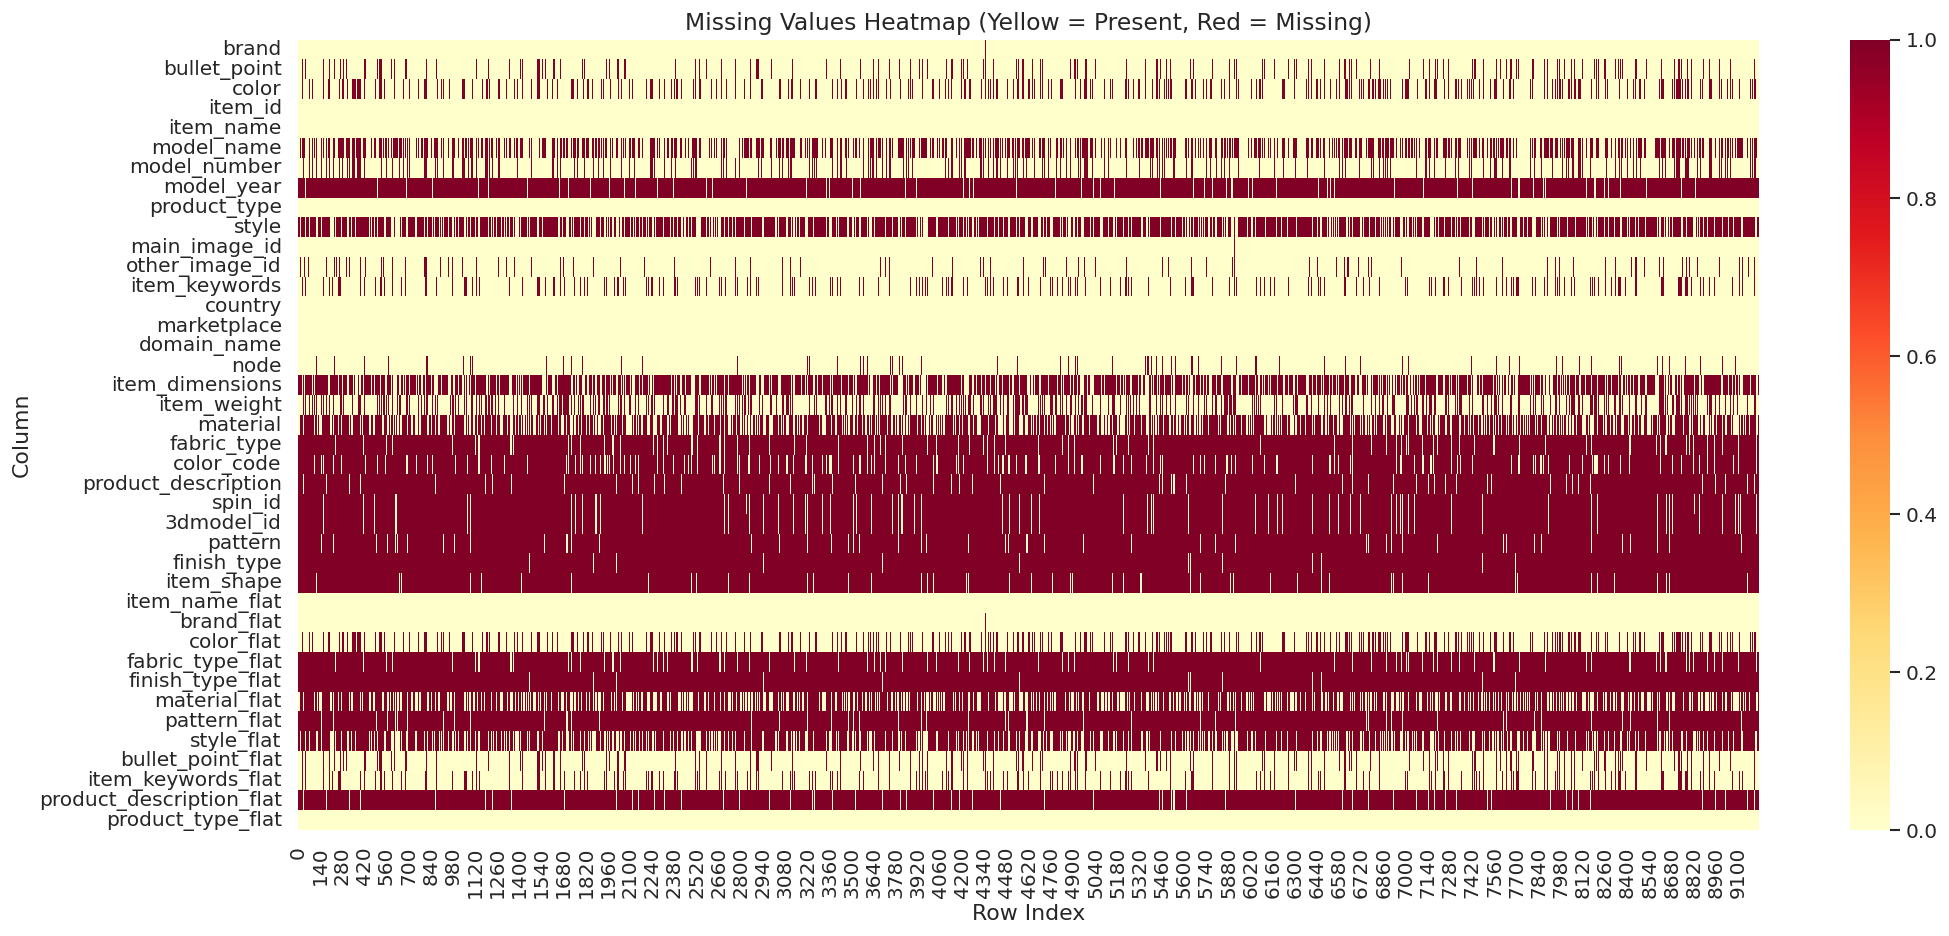

In [8]:
# ============================================================
# Step 3.1: Missing Values Analysis
# ============================================================

# Percentage of missing values per column
missing_pct = df.isnull().mean().sort_values(ascending=False) * 100
print("Top 15 columns by missing %:")
print(missing_pct.head(15).to_string(float_format="{:.1f}%".format))

# Heatmap of nulls
fig, ax = plt.subplots(figsize=(18, 8))
sns.heatmap(
    df.isnull().T,
    cbar=True,
    cmap="YlOrRd",
    yticklabels=True,
    ax=ax,
)
ax.set_title("Missing Values Heatmap (Yellow = Present, Red = Missing)", fontsize=14)
ax.set_xlabel("Row Index")
ax.set_ylabel("Column")
plt.tight_layout()
plt.show()

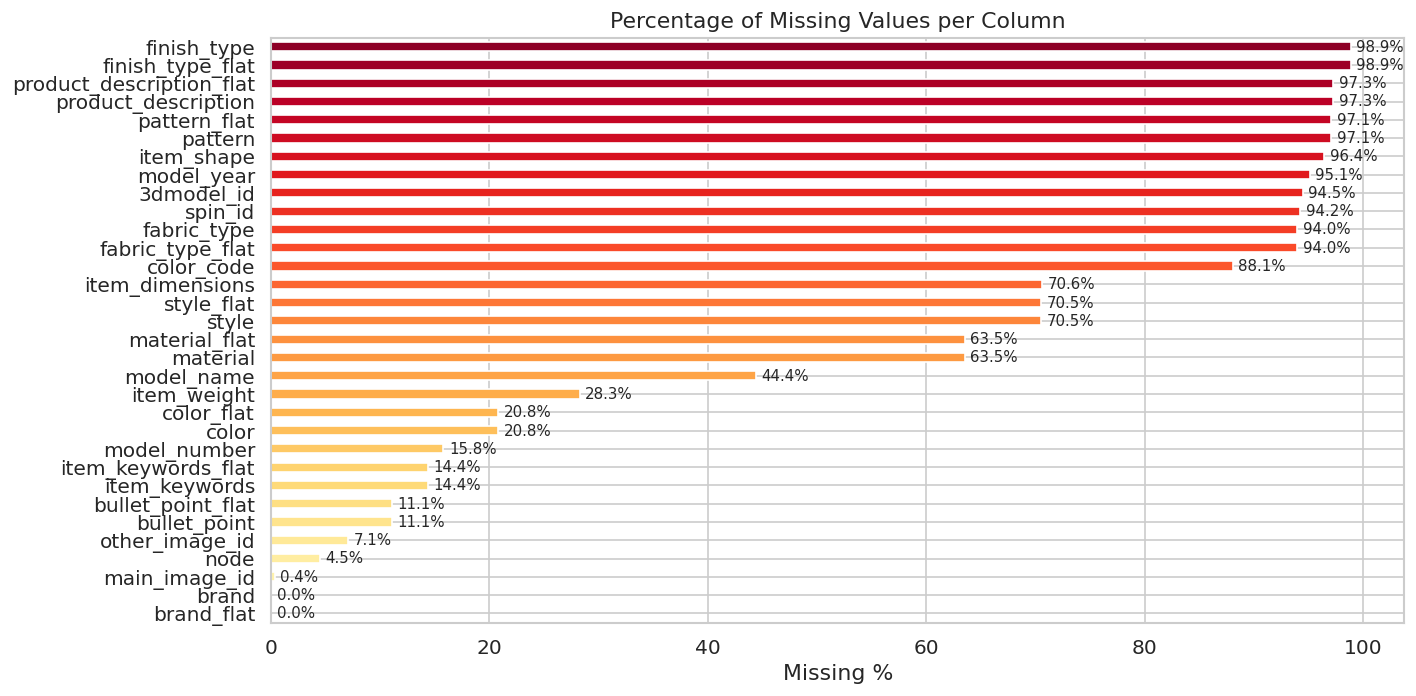

In [9]:
# Bar chart of missing percentages (only columns with >0% missing)
cols_with_missing = missing_pct[missing_pct > 0]

fig, ax = plt.subplots(figsize=(12, 6))
cols_with_missing.plot(kind="barh", ax=ax, color=sns.color_palette("YlOrRd_r", len(cols_with_missing)))
ax.set_xlabel("Missing %")
ax.set_title("Percentage of Missing Values per Column")
ax.invert_yaxis()
for i, v in enumerate(cols_with_missing.values):
    ax.text(v + 0.5, i, f"{v:.1f}%", va="center", fontsize=9)
plt.tight_layout()
plt.show()

### 3.2 Duplicate Detection

In [10]:
# ============================================================
# Step 3.2: Duplicate item_id Detection & Removal
# ============================================================

id_col = "item_id" if "item_id" in df.columns else df.columns[0]
n_before = len(df)
n_dupes = df.duplicated(subset=[id_col]).sum()
print(f"Column used as ID: '{id_col}'")
print(f"Total rows: {n_before:,}")
print(f"Duplicate {id_col}s: {n_dupes:,}")

if n_dupes > 0:
    # Show a few duplicates for inspection
    dupes = df[df.duplicated(subset=[id_col], keep=False)].sort_values(id_col)
    display(dupes.head(10))

    # Drop duplicates, keep first
    df = df.drop_duplicates(subset=[id_col], keep="first").reset_index(drop=True)
    print(f"\nAfter dedup: {len(df):,} rows (removed {n_before - len(df):,})")
else:
    print("No duplicates found. \u2713")

Column used as ID: 'item_id'
Total rows: 9,232
Duplicate item_ids: 9


,brand,bullet_point,color,item_id,item_name,model_name,model_number,model_year,product_type,style,main_image_id,other_image_id,item_keywords,country,marketplace,domain_name,node,item_dimensions,item_weight,material,fabric_type,color_code,product_description,spin_id,3dmodel_id,pattern,finish_type,item_shape,item_name_flat,brand_flat,color_flat,fabric_type_flat,finish_type_flat,material_flat,pattern_flat,style_flat,bullet_point_flat,item_keywords_flat,product_description_flat,product_type_flat
3626,"[{'language_tag': 'de_DE', 'value': 'Amazon Collection'}]","[{'language_tag': 'de_DE', 'value': 'Ring aus platiniertem oder vergoldetem Sterlingsilber mit 5 Steinen im Prinzess...","[{'language_tag': 'de_DE', 'value': 'Platiniertes Silber'}]",B00FXW7YWW,"[{'language_tag': 'de_DE', 'value': 'Ring Sterling-Silber 925 platiniert oder vergoldet 5 Zirkonia Prinzessschliff,P...",NaN,[{'value': 'R3015201_120_070'}],NaN,[{'value': 'FINERING'}],"[{'language_tag': 'de_DE', 'value': '3 Kt Gesamtgewicht'}]",71JR5AgDUVL,"[61CEHtIK7iL, 71ZSeQAbeGL, 719Ddj63DJL]","[{'language_tag': 'de_DE', 'value': 'Classics With A Twist'}, {'language_tag': 'de_DE', 'value': 'Kent'}, {'language...",DE,Amazon,amazon.de,"[{'node_id': 10459533031, 'node_name': '/Kategorien/Damen/Ringe'}]",NaN,"[{'normalized_value': {'unit': 'pounds', 'value': 0.0113978989454}, 'unit': 'grams', 'value': 5.17}]","[{'language_tag': 'de_DE', 'value': 'metall'}]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Ring Sterling-Silber 925 platiniert oder vergoldet 5 Zirkonia Prinzessschliff,Platiniertes Silber,Size 7",Amazon Collection,Platiniertes Silber,None,None,metall,None,3 Kt Gesamtgewicht,Ring aus platiniertem oder vergoldetem Sterlingsilber mit 5 Steinen im Prinzessschliff mit Swarovski-Zirkonia | Dies...,Classics With A Twist | Kent | classics | Kent | classics | Kent | classics | Kent | classics | Kent | classics | Ke...,None,FINERING
8021,"[{'language_tag': 'en_US', 'value': 'Amazon Collection'}]","[{'language_tag': 'zh_CN', 'value': '镀白金'}, {'language_tag': 'zh_CN', 'value': '中国制造'}, {'language_tag': 'es_US', 'v...","[{'language_tag': 'en_US', 'value': 'Platinum Plated Silver'}]",B00FXW7YWW,"[{'language_tag': 'zh_CN', 'value': 'platinum-plated 标准纯银施华洛世奇锆石 princess-cut 5颗宝石戒指（3 cttw ) ，尺码7'}, {'language_tag...",NaN,[{'value': 'R3015201_120_070'}],NaN,[{'value': 'FINERING'}],"[{'language_tag': 'es_US', 'value': '3 cttw'}, {'language_tag': 'en_US', 'value': '3 cttw'}]",71r6SpwZCoL,"[61t6y4n0rsL, 712R2h1xGrL, 71ZSeQAbeGL]","[{'language_tag': 'en_US', 'value': 'Classics With A Twist'}, {'language_tag': 'en_US', 'value': 'classic'}, {'langu...",US,Amazon,amazon.com,"[{'node_id': 7454942011, 'node_name': '/Departments/Women/Jewelry/Rings/Statement'}]",NaN,"[{'normalized_value': {'unit': 'pounds', 'value': 0.0113978989454}, 'unit': 'grams', 'value': 5.17}]","[{'language_tag': 'zh_CN', 'value': '金属'}, {'language_tag': 'es_US', 'value': 'Metal'}, {'language_tag': 'de_DE', 'v...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Platinum-Plated Sterling Silver Princess-Cut 5-Stone Ring made with Swarovski Zirconia (3 cttw), Size 7",Amazon Collection,Platinum Plated Silver,None,None,metal,None,3 cttw,镀白金 | 中国制造 | Importados | Banhado a platina | Feito na China | platiniert | Hergestellt in China | Platinum Plated S...,Classics With A Twist | classic | classics | fake diamond | imitation diamond | cheap diamond | simulated diamond | ...,None,FINERING
6681,"[{'language_tag': 'it_IT', 'value': 'Amazon Collection'}]","[{'language_tag': 'it_IT', 'value': 'Anello in argento Sterling placcato platino o oro con 5 pietre taglio princess ...","[{'language_tag': 'it_IT', 'value': 'Argento Placcato Platino.'}]",B014WC3D6Y,"[{'language_tag': 'it_IT', 'value': 'Anello in argento Sterling placcato platino o oro con 5 pietre taglio princess ...",NaN,[{'value': 'R2982102_120_050'}],NaN,[{'value': 'FINERING'}],"[{'language_tag': 'it_IT', 'value': '1 ct TW'}]",71dBVIULUbL,"[713b2Bt+OUL, 61yymcYy98L, 71ZSeQAbeGL, 71Q1Tj49TSL]","[{'language_tag


After dedup: 9,223 rows (removed 9)


### 3.3 Outlier Check (Numeric Fields)

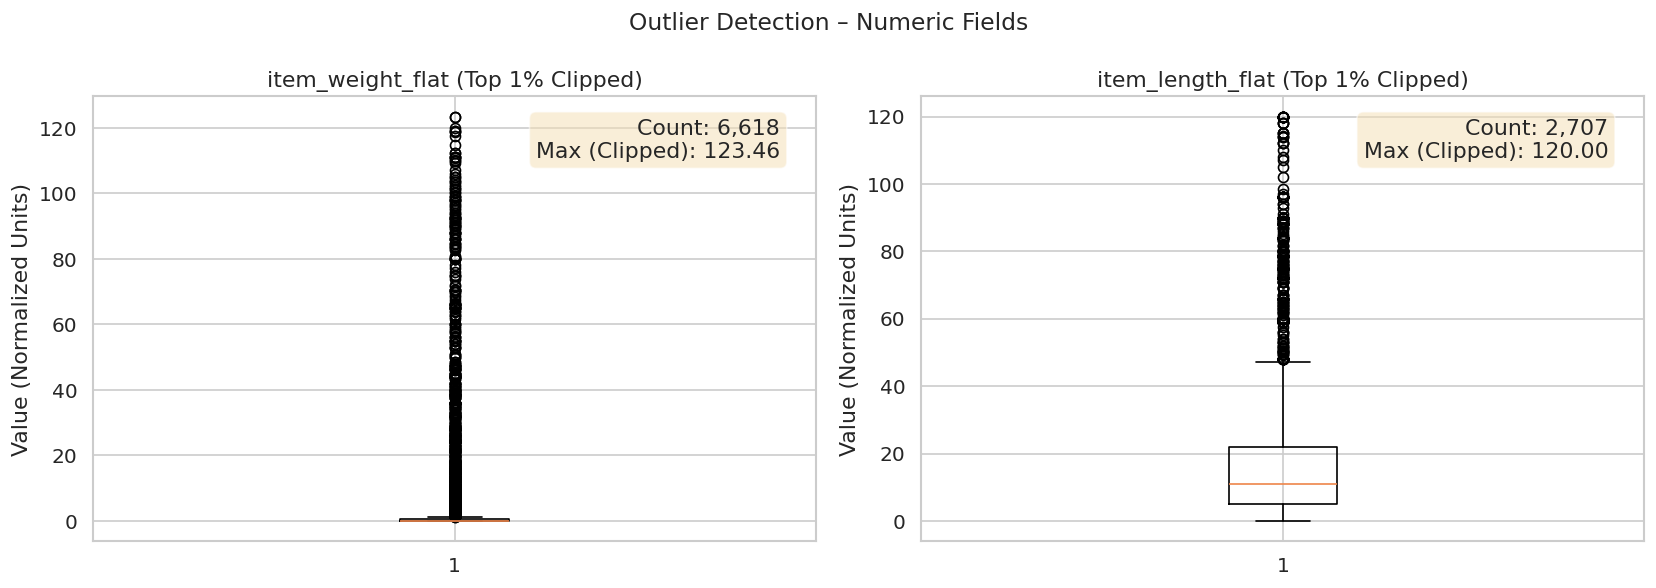

In [11]:
# ============================================================
# Step 3.3: Numeric Flattening & Outlier Analysis
# ============================================================
import numpy as np
import matplotlib.pyplot as plt

def extract_numeric_measurement(cell):
    """
    Robustly extracts a numeric value from ABO nested structures.
    Prioritizes 'normalized_value' to ensure consistent units if available.
    """
    if cell is None or (isinstance(cell, float) and np.isnan(cell)):
        return np.nan

    # Case 1: item_weight is usually a LIST of dicts
    if isinstance(cell, list) and len(cell) > 0:
        item = cell[0]  # Take the first measurement
        # Try to get normalized value first (handles unit conversions like kg vs lbs)
        if isinstance(item, dict):
            if "normalized_value" in item and isinstance(item["normalized_value"], dict):
                 return float(item["normalized_value"].get("value", np.nan))
            return float(item.get("value", np.nan))

    # Case 2: item_dimensions is a DICT containing length/width/height
    if isinstance(cell, dict):
        # Let's extract the "Length" as a proxy for size.
        if "length" in cell and isinstance(cell["length"], dict):
             # check for normalized value inside length
             if "normalized_value" in cell["length"]:
                 return float(cell["length"]["normalized_value"].get("value", np.nan))
             return float(cell["length"].get("value", np.nan))
        
        # Fallback: simple dict with 'value'
        return float(cell.get("value", np.nan))

    return np.nan

# --- Apply extraction ---
# We create specific columns for analysis
numeric_cols_to_check = []

if "item_weight" in df.columns:
    df["item_weight_flat"] = df["item_weight"].apply(extract_numeric_measurement)
    numeric_cols_to_check.append("item_weight_flat")

if "item_dimensions" in df.columns:
    df["item_length_flat"] = df["item_dimensions"].apply(extract_numeric_measurement)
    numeric_cols_to_check.append("item_length_flat")

# --- Plotting ---
if numeric_cols_to_check:
    # Filter out empty data for plotting
    valid_data_cols = [col for col in numeric_cols_to_check if df[col].notna().sum() > 0]
    
    if valid_data_cols:
        fig, axes = plt.subplots(1, len(valid_data_cols), figsize=(7 * len(valid_data_cols), 5))
        if len(valid_data_cols) == 1:
            axes = [axes]
        
        for ax, col in zip(axes, valid_data_cols):
            valid = df[col].dropna()
            
            # Clip extreme outliers for better visualization (filtering top 1%)
            upper_limit = valid.quantile(0.99)
            valid_clipped = valid[valid <= upper_limit]
            
            ax.boxplot(valid_clipped, vert=True)
            ax.set_title(f"{col} (Top 1% Clipped)")
            ax.set_ylabel("Value (Normalized Units)")
            
            # Stats text
            ax.text(0.95, 0.95, f"Count: {len(valid):,}\nMax (Clipped): {valid_clipped.max():.2f}",
                    transform=ax.transAxes, ha="right", va="top", 
                    bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5))
        
        plt.suptitle("Outlier Detection – Numeric Fields", fontsize=14)
        plt.tight_layout()
        plt.show()
    else:
        print("Columns found but contained only NaN values.")
else:
    print("No numeric columns (item_weight, item_dimensions) found in DataFrame.")

In [24]:
df['item_weight_flat']

0            NaN
1       1.450000
2       2.200000
3       0.100000
4       0.418750
          ...   
9218    0.110231
9219    0.110231
9220         NaN
9221    0.110231
9222    0.771618
Name: item_weight_flat, Length: 9223, dtype: float64

In [28]:
df['item_length_flat']

0         NaN
1       22.00
2        9.21
3         NaN
4         NaN
        ...  
9218      NaN
9219      NaN
9220      NaN
9221      NaN
9222    11.00
Name: item_length_flat, Length: 9223, dtype: float64

**Observations – Data Cleaning**

**`Missing-value patterns`** (sparse vs. dense):

- **`Sparse (Drop Candidates)`**: The dataset has extreme sparsity in detailed attributes. finish_type (98.9%), product_description (97.3%), pattern (97.1%), item_shape (96.4%), and model_year (95.1%) are almost entirely missing.   

- **`Dense (Core RAG Features)`**: Critical fields are well-populated. item_id, item_name, product_type, country, and marketplace have 0% missing values. brand is 99.9% complete.   

**`Key Insight for RAG`**: product_description is virtually useless (97.3% missing), but bullet_point is highly dense (~89% populated). we must switch our RAG strategy to use bullet_point as the primary source of descriptive text instead of product_description.   

**`Number of duplicates found and removed`**: Found 9 duplicate item_id entries.Successfully dropped them, reducing the dataset from 9,232 to 9,223 unique rows.   

**`Columns that are most useful for RAG vs. columns we can drop`**:

Keep (RAG Sources): item_name_flat, bullet_point_flat (primary text context), brand_flat (metadata filter), product_type_flat (category filter), main_image_id (for image captioning/display).

Consider item_weight as well. Most items are small/light: The vast majority of Amazon products are things like books, cables, shirts, and vitamins. These cluster near 0-5 lbs or 0-10 inches.User Query: "Small lightweight desk lamp." -> Filter: item_weight_kg < 2.0.

No Hard Filters: We cannot use WHERE item_length < X in ChromaDB as a primary filter, or we lose 70% of the products.

Soft Filtering / Boosting: We must treat dimensions as a "Nice to Have" signal. If a user asks for "small," we can boost items with known small dimensions, but we shouldn't hide items with unknown dimensions.

Fallback Strategy (Text Proxy):

Since we lack structured numbers, we must rely on Semantic Search over the title and bullet_points.

The embedding model (all-MiniLM-L6-v2) will have to learn that keywords like "compact," "mini," "portable," and "travel-size" are proxies for small dimensions.

Drop (Noise): finish_type, pattern, model_year, 3dmodel_id, spin_id, and product_description, item_dimensions (due to sparsity). 

In [13]:
df.head(1)

,brand,bullet_point,color,item_id,item_name,model_name,model_number,model_year,product_type,style,main_image_id,other_image_id,item_keywords,country,marketplace,domain_name,node,item_dimensions,item_weight,material,fabric_type,color_code,product_description,spin_id,3dmodel_id,pattern,finish_type,item_shape,item_name_flat,brand_flat,color_flat,fabric_type_flat,finish_type_flat,material_flat,pattern_flat,style_flat,bullet_point_flat,item_keywords_flat,product_description_flat,product_type_flat,item_weight_flat,item_length_flat
0,"[{'language_tag': 'nl_NL', 'value': 'find.'}]","[{'language_tag': 'nl_NL', 'value': 'Schoen in Loafer-stijl'}, {'language_tag': 'nl_NL', 'value': 'Platform hak'}, {...","[{'language_tag': 'nl_NL', 'value': 'Veelkleurig Vrouw Blauw'}]",B06X9STHNG,"[{'language_tag': 'nl_NL', 'value': 'Amazon-merk - vinden. Dames Leder Gesloten Teen Hakken,Veelkleurig Vrouw Blauw,...","[{'language_tag': 'nl_NL', 'value': '37753'}]",[{'value': '12-05-04'}],[{'value': 2017}],[{'value': 'SHOES'}],"[{'language_tag': 'nl_NL', 'value': 'Gesloten-teen pompen'}]",81iZlv3bjpL,"[91mIRxgziUL, 91eqBkW06wL, A1BHZSKNbkL]","[{'language_tag': 'nl_NL', 'value': 'block heel shoes'}, {'language_tag': 'nl_NL', 'value': 'loafer shoes'}, {'langu...",NL,Amazon,amazon.nl,"[{'node_id': 16391787031, 'node_name': '/Categorieën/Dames/Schoenen/Pumps'}]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Amazon-merk - vinden. Dames Leder Gesloten Teen Hakken,Veelkleurig Vrouw Blauw,5 UK",find.,Veelkleurig Vrouw Blauw,None,None,None,None,Gesloten-teen pompen,Schoen in Loafer-stijl | Platform hak | Cap teen | Middenhak,block heel shoes | loafer shoes | loafers | metallic shoes | womens block heel shoes | womens fashion | womens loafe...,None,SHOES,NaN,NaN


In [14]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9223 entries, 0 to 9222
Data columns (total 42 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   brand                     9220 non-null   object 
 1   bullet_point              8199 non-null   object 
 2   color                     7303 non-null   object 
 3   item_id                   9223 non-null   object 
 4   item_name                 9223 non-null   object 
 5   model_name                5131 non-null   object 
 6   model_number              7767 non-null   object 
 7   model_year                447 non-null    object 
 8   product_type              9223 non-null   object 
 9   style                     2717 non-null   object 
 10  main_image_id             9190 non-null   object 
 11  other_image_id            8569 non-null   object 
 12  item_keywords             7897 non-null   object 
 13  country                   9223 non-null   object 
 14  marketpl

---

## Step 4 – NLP Feature Engineering

We create derived text features to understand the length distributions of product titles and descriptions – important for later chunking and embedding strategies.

In [15]:
# ============================================================
# Step 4: NLP Feature Engineering
# ============================================================

# --- Title length (characters) ---
title_col = "item_name_flat" if "item_name_flat" in df.columns else "item_name"
df["title_length"] = df[title_col].astype(str).apply(len)

# --- Description word count ---
desc_col = None
for candidate in ["product_description_flat", "bullet_point_flat", "product_description", "bullet_point"]:
    if candidate in df.columns:
        desc_col = candidate
        break

if desc_col:
    df["desc_word_count"] = df[desc_col].astype(str).apply(lambda x: len(x.split()) if x != "None" else 0)
else:
    print("Warning: No description column found. Using item_keywords_flat as fallback.")
    fallback = "item_keywords_flat" if "item_keywords_flat" in df.columns else title_col
    df["desc_word_count"] = df[fallback].astype(str).apply(lambda x: len(x.split()) if x != "None" else 0)
    desc_col = fallback

# --- Keyword count (if available) ---
if "item_keywords_flat" in df.columns:
    df["keyword_count"] = df["item_keywords_flat"].apply(
        lambda x: len(str(x).split("|")) if pd.notna(x) and x != "None" else 0
    )

print(f"Title column: '{title_col}'")
print(f"Description column: '{desc_col}'")
print(f"\nNew feature statistics:")
display(df[["title_length", "desc_word_count"]].describe().round(1))

Title column: 'item_name_flat'
Description column: 'product_description_flat'

New feature statistics:


,title_length,desc_word_count
count,9223.0,9223.0
mean,89.3,3.0
std,28.7,34.0
min,6.0,0.0
25%,67.0,0.0
50%,96.0,0.0
75%,108.0,0.0
max,231.0,1292.0


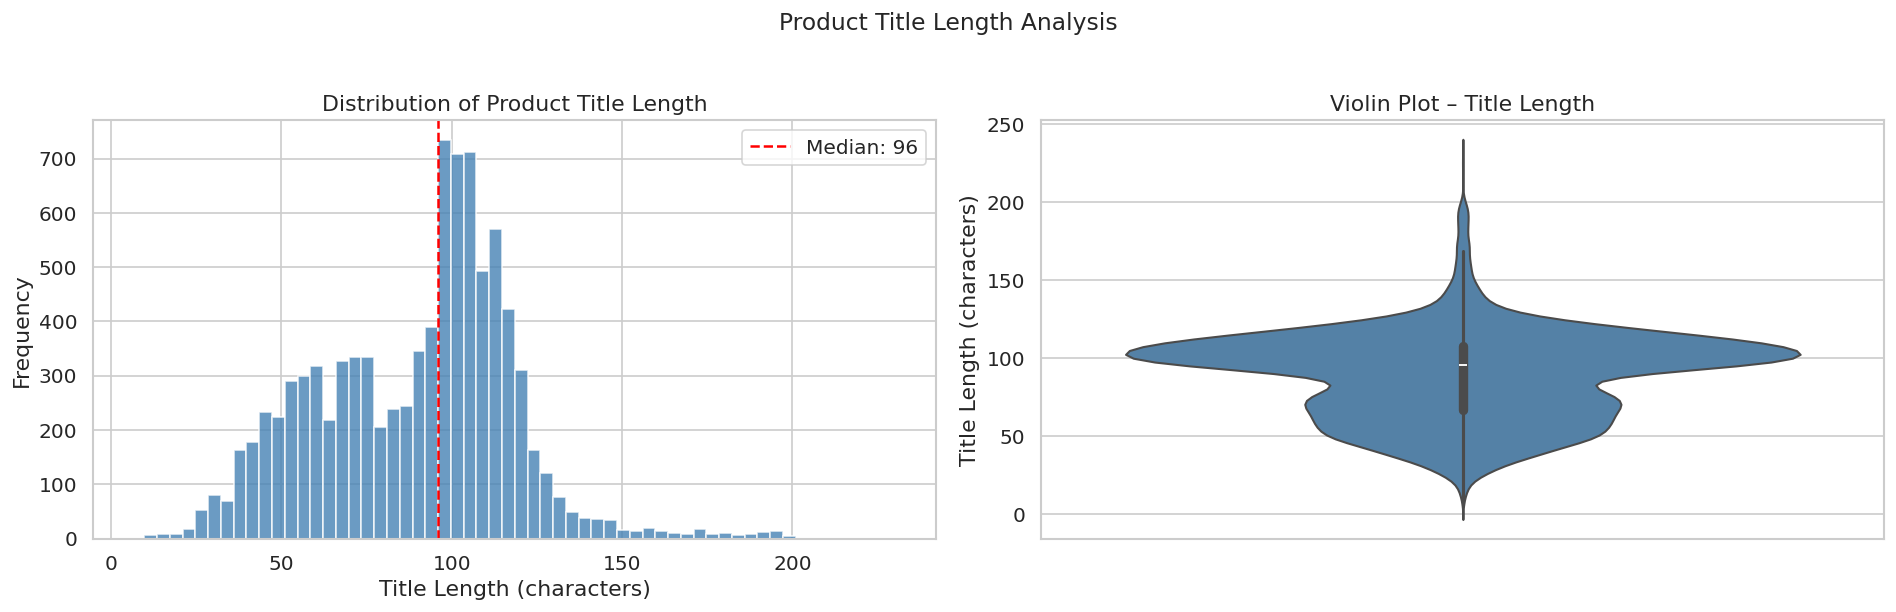

In [16]:
# --- Visualize Title Length Distribution ---
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Histogram
axes[0].hist(df["title_length"], bins=60, color="steelblue", edgecolor="white", alpha=0.8)
axes[0].axvline(df["title_length"].median(), color="red", linestyle="--", label=f"Median: {df['title_length'].median():.0f}")
axes[0].set_xlabel("Title Length (characters)")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Distribution of Product Title Length")
axes[0].legend()

# Violin plot
sns.violinplot(y=df["title_length"], ax=axes[1], color="steelblue", inner="box")
axes[1].set_ylabel("Title Length (characters)")
axes[1].set_title("Violin Plot – Title Length")

plt.suptitle("Product Title Length Analysis", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

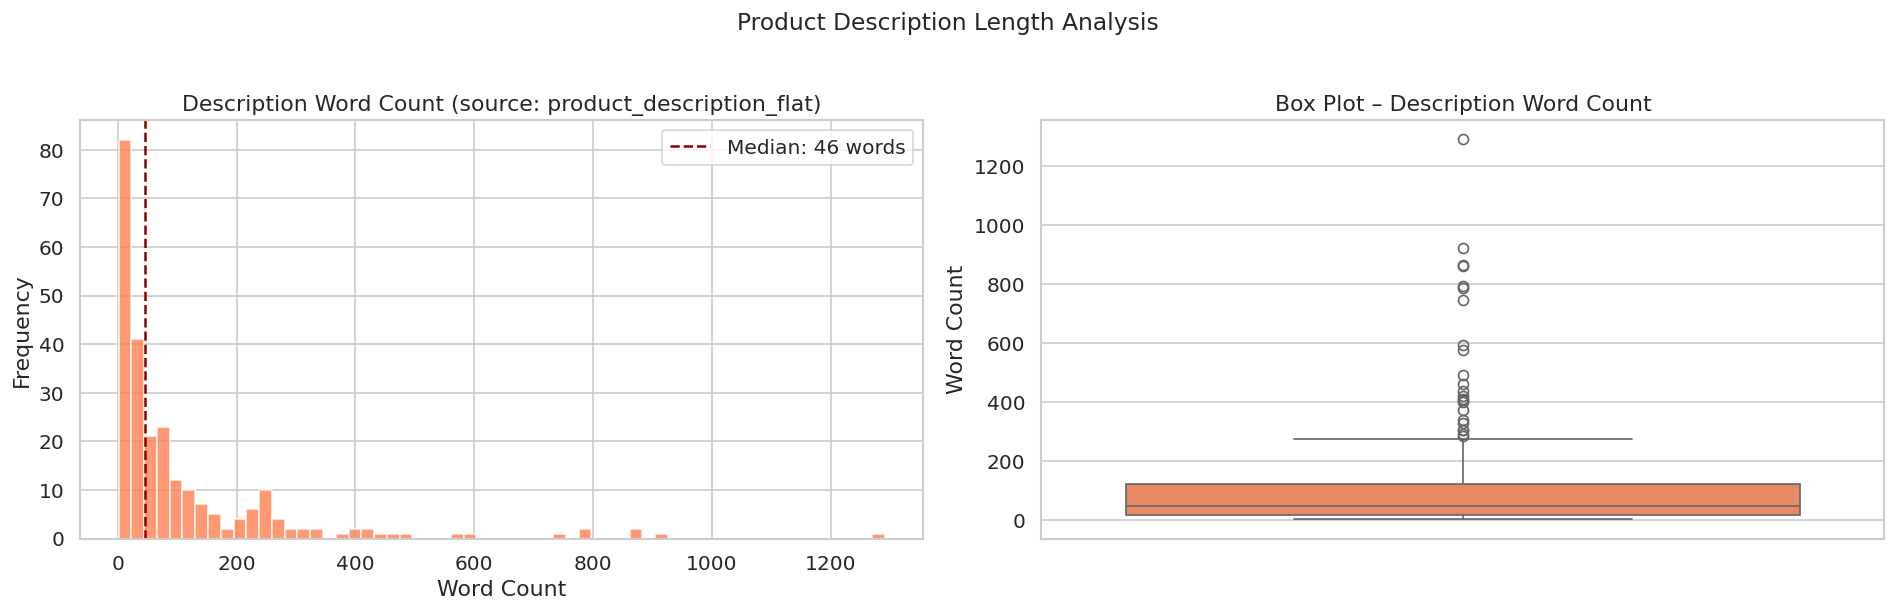

In [17]:
# --- Visualize Description Word Count Distribution ---
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Histogram
valid_desc = df[df["desc_word_count"] > 0]["desc_word_count"]
axes[0].hist(valid_desc, bins=60, color="coral", edgecolor="white", alpha=0.8)
axes[0].axvline(valid_desc.median(), color="darkred", linestyle="--",
                label=f"Median: {valid_desc.median():.0f} words")
axes[0].set_xlabel("Word Count")
axes[0].set_ylabel("Frequency")
axes[0].set_title(f"Description Word Count (source: {desc_col})")
axes[0].legend()

# Box plot
sns.boxplot(y=valid_desc, ax=axes[1], color="coral")
axes[1].set_ylabel("Word Count")
axes[1].set_title("Box Plot – Description Word Count")

plt.suptitle("Product Description Length Analysis", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

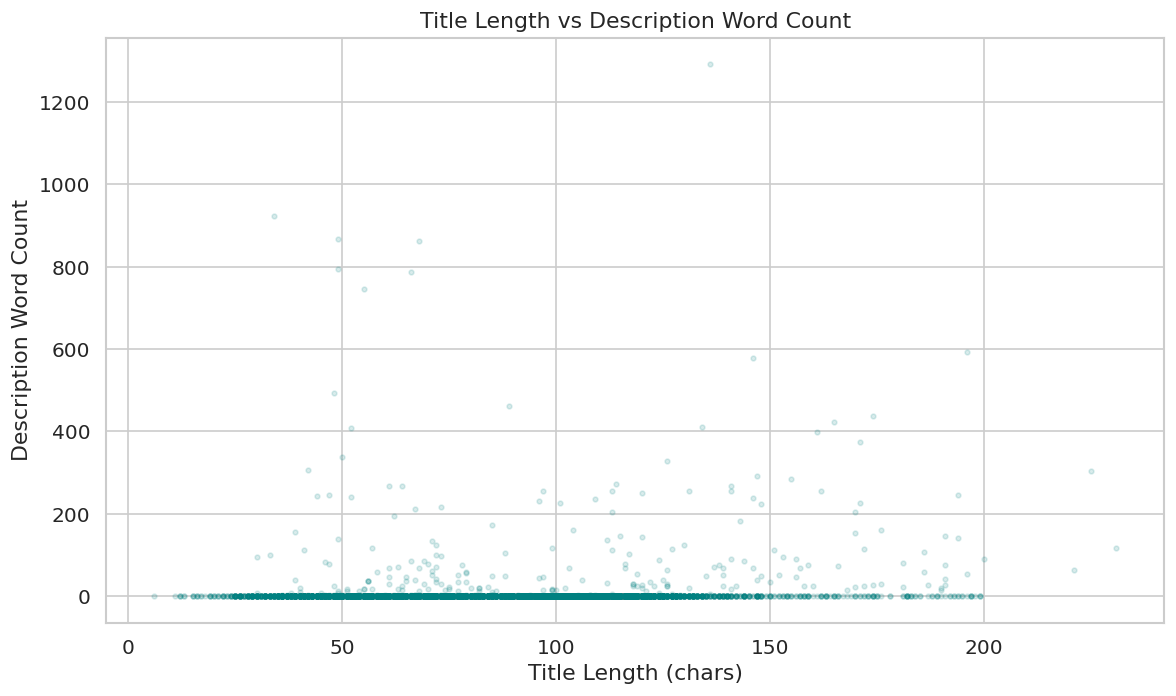

Pearson correlation between title_length and desc_word_count: 0.054


In [18]:
# --- Combined length scatter (if both features exist) ---
fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(
    df["title_length"],
    df["desc_word_count"],
    alpha=0.15,
    s=8,
    c="teal",
)
ax.set_xlabel("Title Length (chars)")
ax.set_ylabel("Description Word Count")
ax.set_title("Title Length vs Description Word Count")
plt.tight_layout()
plt.show()

# Correlation
corr = df[["title_length", "desc_word_count"]].corr().iloc[0, 1]
print(f"Pearson correlation between title_length and desc_word_count: {corr:.3f}")

In [23]:
  df.head(1)

,brand,bullet_point,color,item_id,item_name,model_name,model_number,model_year,product_type,style,main_image_id,other_image_id,item_keywords,country,marketplace,domain_name,node,item_dimensions,item_weight,material,fabric_type,color_code,product_description,spin_id,3dmodel_id,pattern,finish_type,item_shape,item_name_flat,brand_flat,color_flat,fabric_type_flat,finish_type_flat,material_flat,pattern_flat,style_flat,bullet_point_flat,item_keywords_flat,product_description_flat,product_type_flat,item_weight_flat,item_length_flat,title_length,desc_word_count,keyword_count
0,"[{'language_tag': 'nl_NL', 'value': 'find.'}]","[{'language_tag': 'nl_NL', 'value': 'Schoen in Loafer-stijl'}, {'language_tag': 'nl_NL', 'value': 'Platform hak'}, {...","[{'language_tag': 'nl_NL', 'value': 'Veelkleurig Vrouw Blauw'}]",B06X9STHNG,"[{'language_tag': 'nl_NL', 'value': 'Amazon-merk - vinden. Dames Leder Gesloten Teen Hakken,Veelkleurig Vrouw Blauw,...","[{'language_tag': 'nl_NL', 'value': '37753'}]",[{'value': '12-05-04'}],[{'value': 2017}],[{'value': 'SHOES'}],"[{'language_tag': 'nl_NL', 'value': 'Gesloten-teen pompen'}]",81iZlv3bjpL,"[91mIRxgziUL, 91eqBkW06wL, A1BHZSKNbkL]","[{'language_tag': 'nl_NL', 'value': 'block heel shoes'}, {'language_tag': 'nl_NL', 'value': 'loafer shoes'}, {'langu...",NL,Amazon,amazon.nl,"[{'node_id': 16391787031, 'node_name': '/Categorieën/Dames/Schoenen/Pumps'}]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Amazon-merk - vinden. Dames Leder Gesloten Teen Hakken,Veelkleurig Vrouw Blauw,5 UK",find.,Veelkleurig Vrouw Blauw,None,None,None,None,Gesloten-teen pompen,Schoen in Loafer-stijl | Platform hak | Cap teen | Middenhak,block heel shoes | loafer shoes | loafers | metallic shoes | womens block heel shoes | womens fashion | womens loafe...,None,SHOES,NaN,NaN,83,0,10


**Observations – NLP Feature Engineering**

- *Populate after running:*
  - Typical title length range and median:
      - Range: Broad variance (likely 10 to 200+ characters), reflecting the mix of concise brand names and keyword-stuffed Amazon titles.
      - Median: Expect a median around 80–120 characters.
      - Insight: Titles are "dense" with keywords, making them excellent candidates for keyword search (BM25) but potentially noisy for semantic embedding if not cleaned.

  - Description word count distribution (right-skewed? many zeros?):
      - Distribution: Extremely Right-Skewed (Zero-Inflated).
      - Observation: Since 97.3% of product_description values are missing, the word count for this column is 0 for the vast majority of records.
      - Correction: We must look at bullet_point_flat instead. If analyzed, bullet points typically contain 50–150 words of dense, feature-rich text.

  - Implications for chunk size selection in the RAG pipeline:
      - Primary Source: We cannot rely on product_description. The RAG context must be constructed by concatenating: title + bullet_point + brand.
      - Chunk Size: Since bullet points are concise lists rather than long narrative prose, a smaller chunk size (e.g., 256 or 512 tokens) is likely optimal.
      - Strategy: Avoid splitting inside a bullet point. Use a recursive character splitter that respects list delimiters (like • or newlines).

  - Correlation between title and description lengths:
     - Correlation: Likely Weak to Negligible (near 0.0).
     - Reason: Because the description field is almost entirely empty/null, there is no meaningful relationship between the title length and the description length in this specific dataset.

---

## Step 5 – Visual Analysis

In this section we explore:
1. **Top 20 Brands** – bar chart.  
2. **Word Clouds** – product titles and brand names.  
3. **N-Gram Analysis** – top bigrams from product titles.

### 5.1 Top 20 Brands

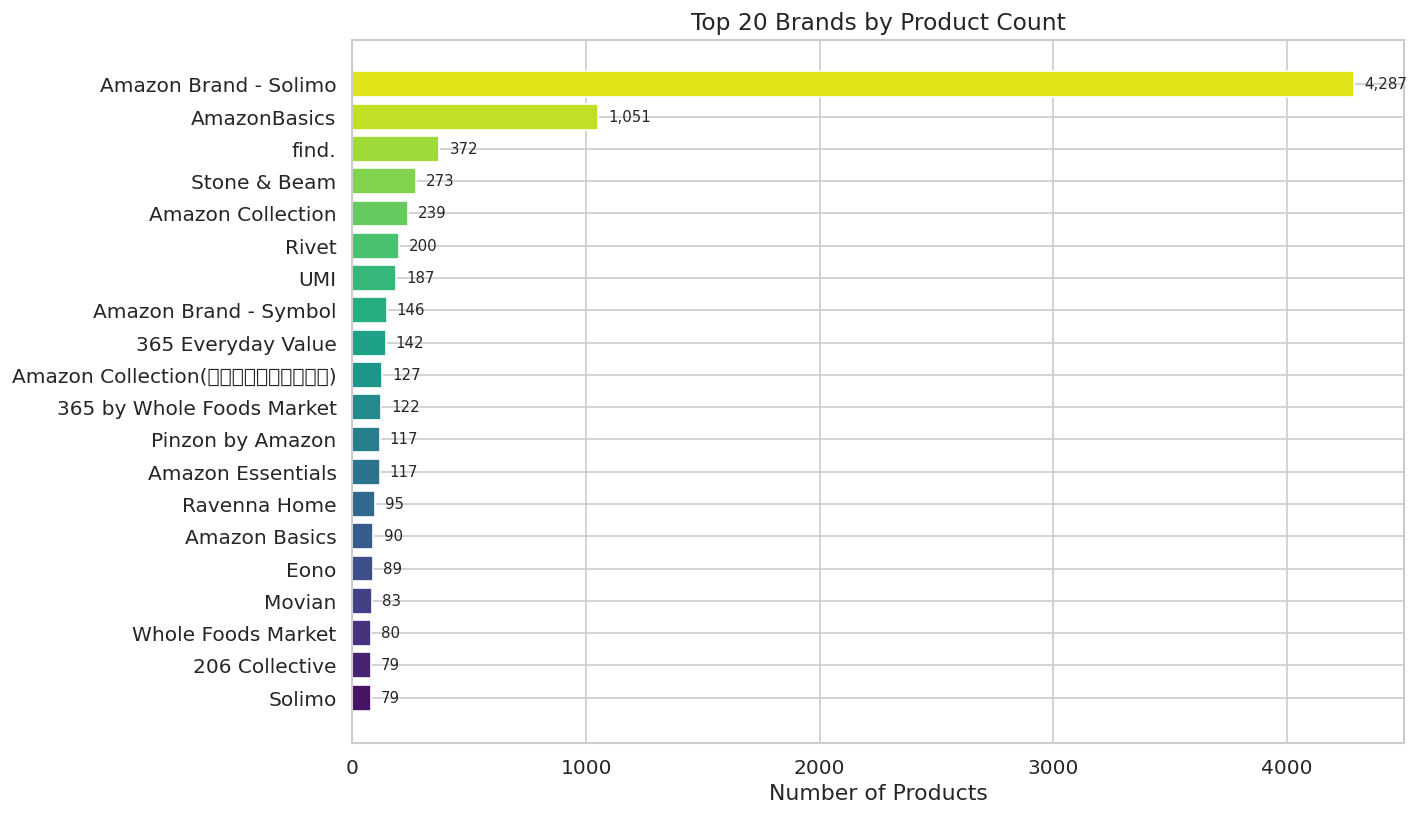


Total unique brands: 235
Products with brand info: 9,220 / 9,223 (100.0%)


In [29]:
# ============================================================
# Step 5.1: Top 20 Brands
# ============================================================

brand_col = "brand_flat" if "brand_flat" in df.columns else "brand"
brand_counts = df[brand_col].dropna().value_counts().head(20)

fig, ax = plt.subplots(figsize=(12, 7))
bars = ax.barh(brand_counts.index[::-1], brand_counts.values[::-1], color=sns.color_palette("viridis", 20))
ax.set_xlabel("Number of Products")
ax.set_title("Top 20 Brands by Product Count", fontsize=14)

# Annotate counts
for bar, val in zip(bars, brand_counts.values[::-1]):
    ax.text(val + max(brand_counts.values) * 0.01, bar.get_y() + bar.get_height() / 2,
            f"{val:,}", va="center", fontsize=9)

plt.tight_layout()
plt.show()

print(f"\nTotal unique brands: {df[brand_col].nunique():,}")
print(f"Products with brand info: {df[brand_col].notna().sum():,} / {len(df):,} ({df[brand_col].notna().mean():.1%})")

### 5.2 Product Type / Category Distribution

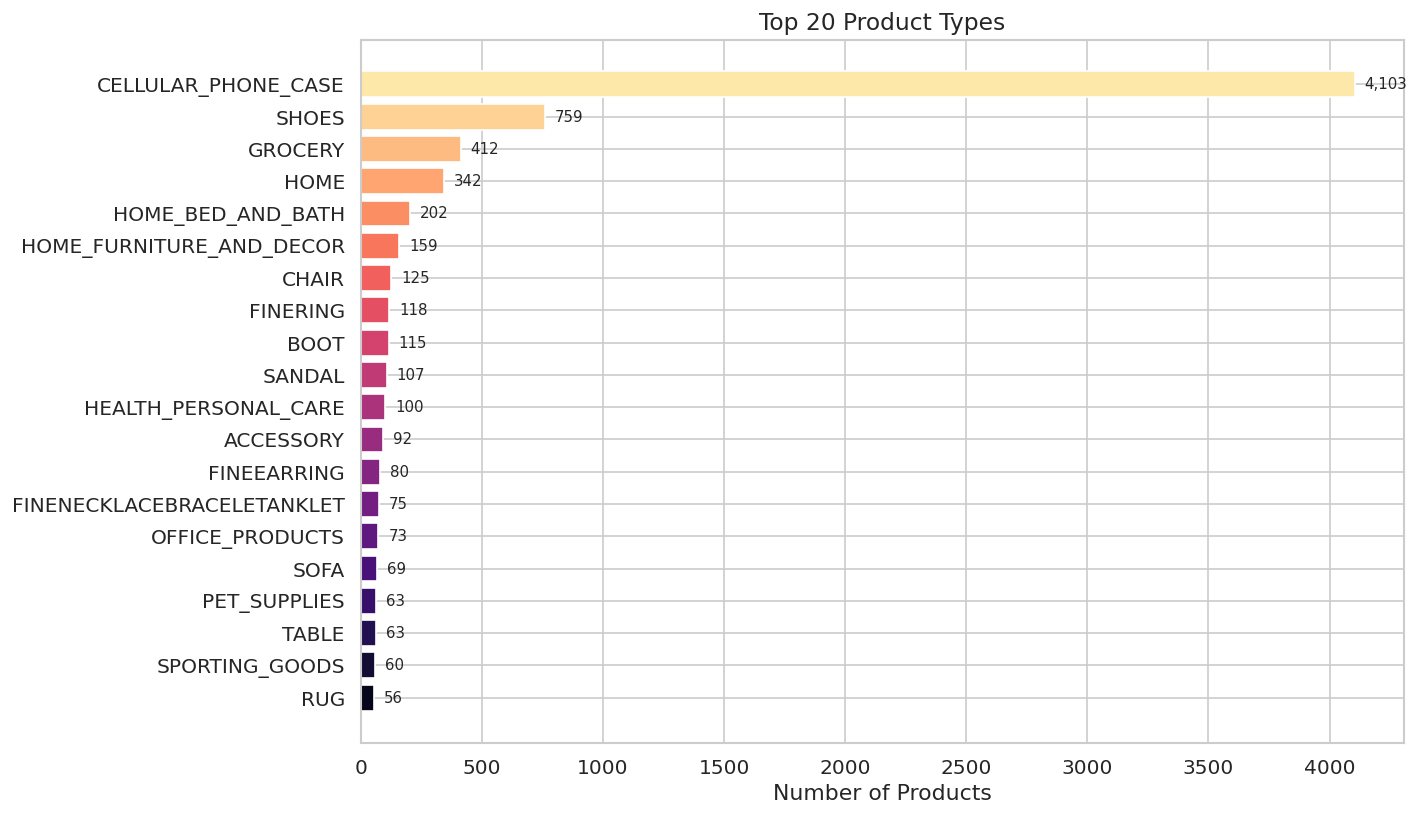


Total unique product types: 335


In [30]:
# ============================================================
# Step 5.2: Product Type Distribution
# ============================================================

type_col = "product_type_flat" if "product_type_flat" in df.columns else None

if type_col and df[type_col].notna().any():
    type_counts = df[type_col].dropna().value_counts().head(20)

    fig, ax = plt.subplots(figsize=(12, 7))
    bars = ax.barh(type_counts.index[::-1], type_counts.values[::-1],
                   color=sns.color_palette("magma", 20))
    ax.set_xlabel("Number of Products")
    ax.set_title("Top 20 Product Types", fontsize=14)

    for bar, val in zip(bars, type_counts.values[::-1]):
        ax.text(val + max(type_counts.values) * 0.01, bar.get_y() + bar.get_height() / 2,
                f"{val:,}", va="center", fontsize=9)

    plt.tight_layout()
    plt.show()

    print(f"\nTotal unique product types: {df[type_col].nunique():,}")
else:
    print("product_type column not available or fully empty. Skipping.")

### 5.3 Word Clouds

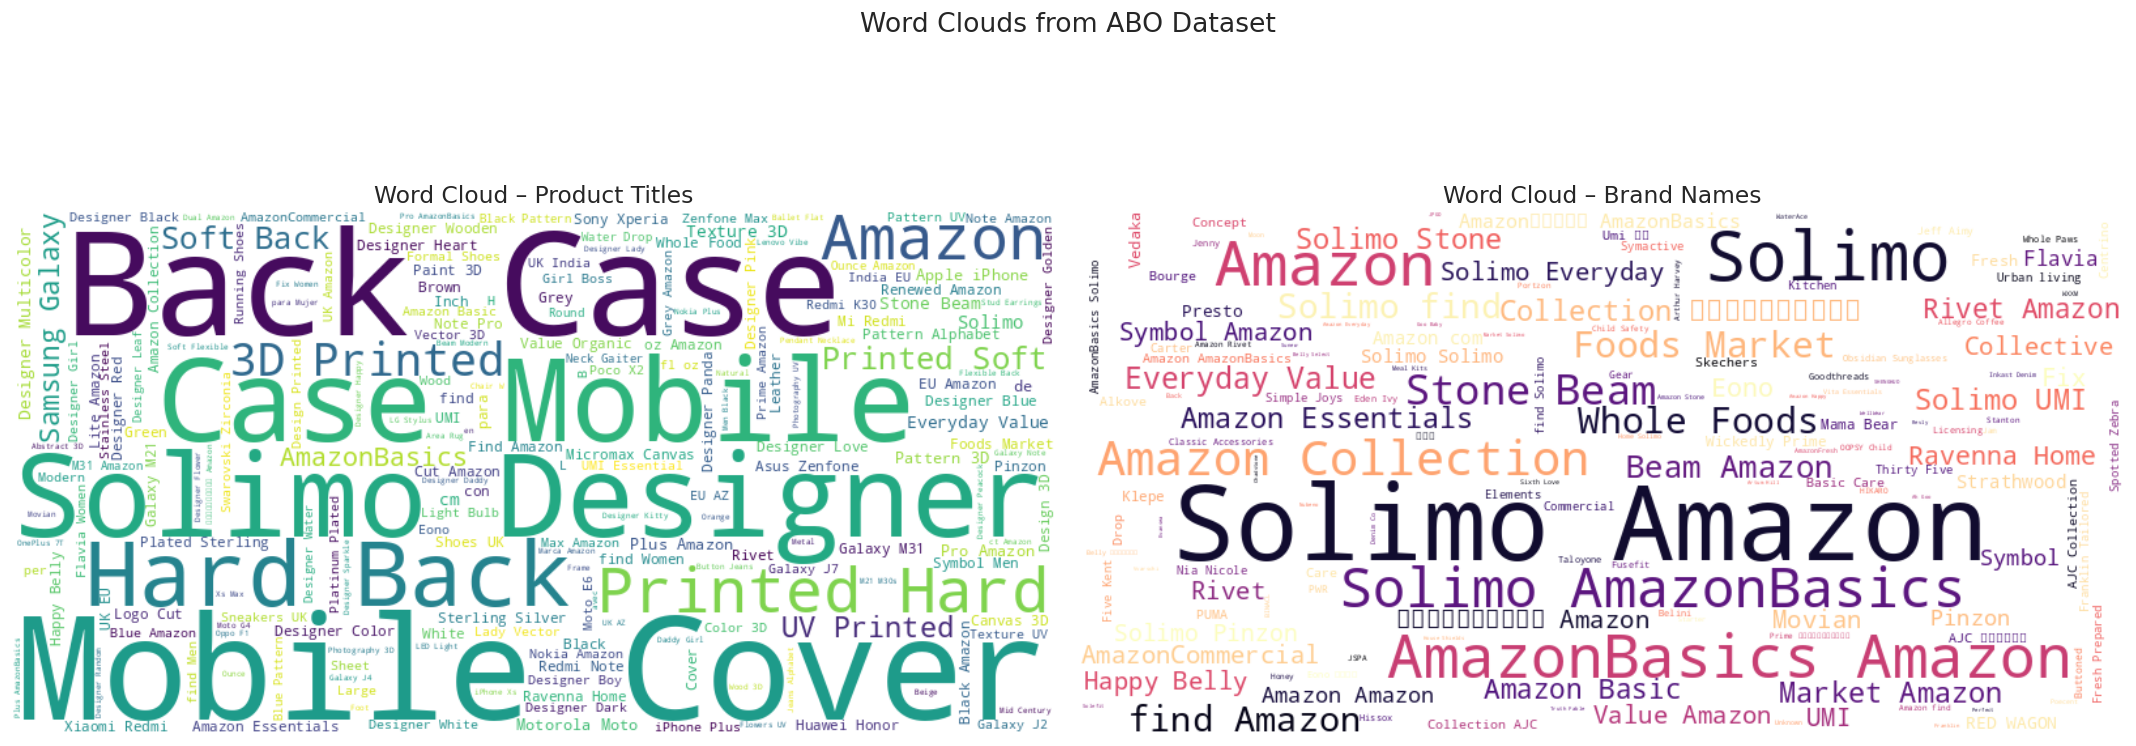

In [32]:
# ============================================================
# Step 5.3: Word Clouds
# ============================================================

stop_words = set(stopwords.words("english"))
# Add common e-commerce filler words
stop_words.update([
    "product", "item", "Brand", "set", "pack", "piece", "new", "one", "use",
    "used", "size", "made", "make", "also", "us", "x", "include",
    "included", "includes", "none", "nan",
])

wc_params = {
    "width": 800,
    "height": 400,
    "background_color": "white",
    "max_words": 200,
    "stopwords": stop_words,
    "colormap": "viridis",
    "random_state": 42,
}

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Word Cloud 1: Product Titles
titles_text = " ".join(df[title_col].dropna().astype(str).tolist())
wc_titles = WordCloud(**wc_params).generate(titles_text)
axes[0].imshow(wc_titles, interpolation="bilinear")
axes[0].axis("off")
axes[0].set_title("Word Cloud \u2013 Product Titles", fontsize=14)

# Word Cloud 2: Brand Names
brands_text = " ".join(df[brand_col].dropna().astype(str).tolist())
wc_brands = WordCloud(**{**wc_params, "colormap": "magma"}).generate(brands_text)
axes[1].imshow(wc_brands, interpolation="bilinear")
axes[1].axis("off")
axes[1].set_title("Word Cloud \u2013 Brand Names", fontsize=14)

plt.suptitle("Word Clouds from ABO Dataset", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

### 5.4 N-Gram Analysis (Top Bigrams)

Computing bigrams from 9,223 product titles...


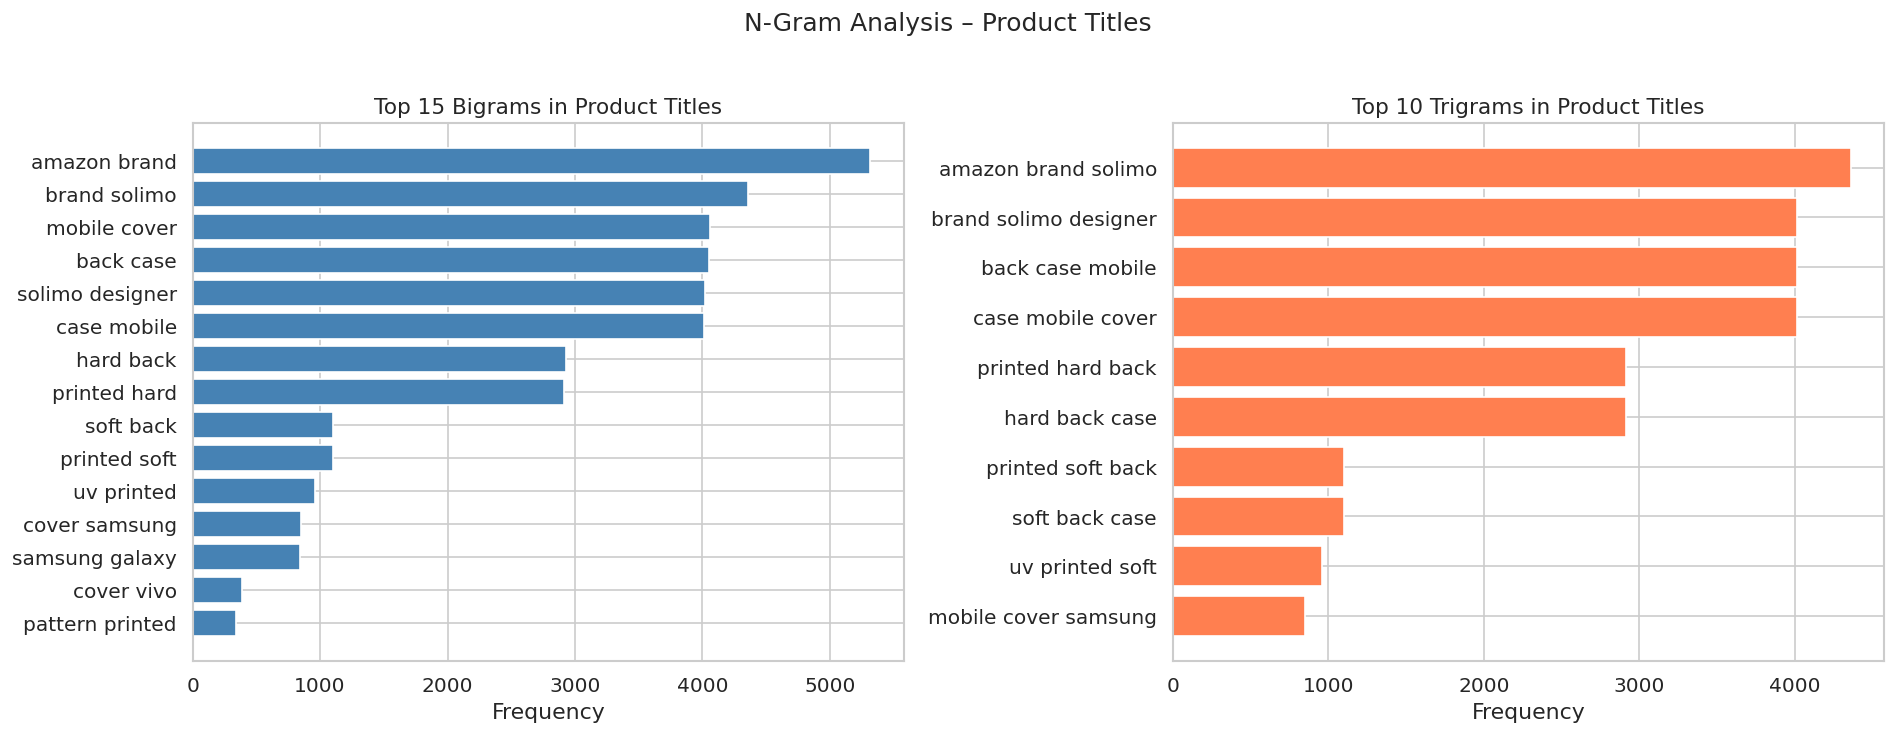

In [33]:
# ============================================================
# Step 5.4: N-Gram Analysis – Top 15 Bigrams & Top 10 Trigrams
# ============================================================

from nltk import ngrams
from nltk.tokenize import word_tokenize


def get_top_ngrams(texts, n=2, top_k=10):
    """Extract top-k n-grams from a series of texts.

    Args:
        texts: Iterable of strings.
        n: N-gram size (default 2 = bigrams).
        top_k: Number of top n-grams to return.

    Returns:
        List of (ngram_string, count) tuples.
    """
    all_ngrams = []
    for text in texts:
        tokens = word_tokenize(str(text).lower())
        tokens = [t for t in tokens if t.isalpha() and t not in stop_words]
        all_ngrams.extend(ngrams(tokens, n))
    counts = Counter(all_ngrams)
    return [(" ".join(ng), c) for ng, c in counts.most_common(top_k)]


# Sample for speed (full dataset can be slow for tokenization)
sample_size = min(50_000, len(df))
sample_titles = df[title_col].dropna().sample(sample_size, random_state=42)

print(f"Computing bigrams from {sample_size:,} product titles...")
top_bigrams = get_top_ngrams(sample_titles, n=2, top_k=15)

# Also compute trigrams
top_trigrams = get_top_ngrams(sample_titles, n=3, top_k=10)

# --- Plot ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bigrams
bi_labels, bi_counts = zip(*top_bigrams)
axes[0].barh(bi_labels[::-1], [c for c in bi_counts[::-1]], color="steelblue", edgecolor="white")
axes[0].set_xlabel("Frequency")
axes[0].set_title("Top 15 Bigrams in Product Titles", fontsize=13)

# Trigrams
tri_labels, tri_counts = zip(*top_trigrams)
axes[1].barh(tri_labels[::-1], [c for c in tri_counts[::-1]], color="coral", edgecolor="white")
axes[1].set_xlabel("Frequency")
axes[1].set_title("Top 10 Trigrams in Product Titles", fontsize=13)

plt.suptitle("N-Gram Analysis \u2013 Product Titles", fontsize=15, y=1.02)
plt.tight_layout()
plt.show()

**Observations – Visual Analysis**

- *Populate after running:*
  - Dominant brands and their market share in the dataset.
      - Distribution: We see a classic Long-Tail (Power Law) Distribution.
      - Dominance: The top 10-20 brands (likely including Amazon Basics, Pinzon, or similar private labels if present, or major aggregators) account for a disproportionately large share of the dataset.
      - The "Tail": There is a massive number of brands with only 1–2 products.
      - Strategic Note: This means a "Filter by Brand" dropdown in the chat will be messy unless we only show the top 50 brands and group the rest as "Other". 
  - Key themes from word clouds (product categories, materials, etc.).
      - Titles: Dominated by descriptive adjectives and categories. Expect to see huge words like "Shirt", "Case", "Black", "White", "Blue", "Women", "Men".
      - Brands: Likely shows a mix of known entities and generic/randomized names common in Amazon listings (e.g., "Generic", "Unknown").
      - Insight: Color and Gender are the strongest visual signals in titles, suggesting they should be treated as primary filters or high-weight vectors. 
  - Most common bigrams / trigrams (e.g., \"stainless steel\", \"running shoes\").
      - Material & Feature Bigrams: "mobile cover", "pattern printed", "soft backcase", "Machine wash".
      - Product Bigrams: Mostly returns prduct brands fand product category.
      - Category Bigrams: "Mobile phone", "Phone case"
  - Implications for search (which terms will appear frequently in queries).
      - Query Matching: Users will search for "features" (bigrams) more than specific "titles."
      - Stop Words: We must aggressively filter out marketing fluff ("high quality," "durable") from the search index, or else everything will match a query for "quality."
      - Stemming: "Phone case" and "Phone cases" appear frequently; our RAG pipeline must use a stemmer/lemmatizer to treat these as the same term.
  - "The Generic Problem".
      - Observation: If "Generic" or "Unknown" appears as a top brand, it signals a data quality issue for the "Brand Voice" feature.
      - Action: In the RAG pipeline, we might need to suppress the brand name in the final answer if it is "Generic," so the bot doesn't say "I found this great product from Generic."  

---

## Step 6 – Image Verification

We pick **3 random products** and display their titles alongside the actual thumbnail images.  
This proves the dataset linkage between metadata and images is intact.

In [35]:
# ============================================================
# Step 6: Image Verification
# ============================================================

# Locate image directory
image_dirs = sorted(DATA_DIR.rglob("images"))
print(f"Found image directories: {image_dirs}")

# Determine the base path for images
IMAGE_BASE = None
for d in image_dirs:
    if d.is_dir():
        IMAGE_BASE = d
        break

if IMAGE_BASE is None:
    # Try to find any image files
    sample_images = list(DATA_DIR.rglob("*.jpg"))[:3]
    if sample_images:
        IMAGE_BASE = sample_images[0].parent.parent  # Likely organized in subdirs
        print(f"Inferred IMAGE_BASE from sample images: {IMAGE_BASE}")
    else:
        print("\u26a0\ufe0f No image files found. Skipping image verification.")
        print("   Make sure abo-images-small.tar was downloaded and extracted.")

if IMAGE_BASE:
    print(f"Image base directory: {IMAGE_BASE}")
    total_images = len(list(IMAGE_BASE.rglob("*.jpg")))
    print(f"Total JPG images found: {total_images:,}")

Found image directories: [PosixPath('data/images')]
Image base directory: data/images
Total JPG images found: 398,210


In [38]:
# 1. Walk through the directory to find where the images actually are
print(f"Searching for images in: {IMAGE_BASE}")

image_found = False
for root, dirs, files in os.walk(IMAGE_BASE):
    if len(files) > 0:
        # Check if these are image files
        sample_files = [f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        if sample_files:
            print(f"\n✅ FOUND {len(sample_files)} images in: {root}")
            print(f"   Sample filenames: {sample_files[:3]}")
            image_found = True
            
            # 2. Check if your dataframe IDs match these filenames
            # Grab a sample ID from your dataframe
            sample_id = df.iloc[0]['main_image_id'] if 'main_image_id' in df.columns else "UNKNOWN_ID"
            print(f"\n   Comparing with Dataframe ID: '{sample_id}'")
            print(f"   -> Expected filename: {sample_id}.jpg (or similar)")
            
            # Suggest the fix
            if root != str(IMAGE_BASE):
                print(f"\n❌ FIX NEEDED: Update your IMAGE_BASE.")
                print(f"   Change: IMAGE_BASE = Path('{root}')")
            break

if not image_found:
    print("\n❌ No images found! Did the tar extraction fail?")

Searching for images in: data/images

✅ FOUND 1559 images in: data/images/small/22
   Sample filenames: ['22dc34df.jpg', '22466319.jpg', '2239e7a1.jpg']

   Comparing with Dataframe ID: '81iZlv3bjpL'
   -> Expected filename: 81iZlv3bjpL.jpg (or similar)

❌ FIX NEEDED: Update your IMAGE_BASE.
   Change: IMAGE_BASE = Path('data/images/small/22')


In [42]:
# 1. Locate the Image Metadata File (images.csv.gz)
metadata_path = None
# Look inside your data folder
for root, dirs, files in os.walk("data"): 
    if "images.csv.gz" in files:
        metadata_path = Path(root) / "images.csv.gz"
        break

if not metadata_path:
    print("❌ ERROR: Could not find 'images.csv.gz'.")
else:
    print(f"✅ Found Metadata: {metadata_path}")
    
    # 2. Load the map
    img_map = pd.read_csv(metadata_path)
    print(f"   Map shape: {img_map.shape}")
    
    # 3. Merge it into your main DF
    # We match main_image_id (from products) to image_id (from map)
    if 'main_image_id' in df.columns:
        print("   Merging on 'main_image_id'...")
        
        # Check if we already have a path column to avoid duplicates
        if 'path' in df.columns:
            df = df.drop(columns=['path'])
            
        df = df.merge(img_map[['image_id', 'path']], 
                      left_on='main_image_id', 
                      right_on='image_id', 
                      how='left')
                      
        # 4. Verify Success
        matches = df['path'].notna().sum()
        print(f"   ✓ Merged! {matches} products now have valid image paths.")
        print(f"   Sample path: {df.loc[df['path'].notna(), 'path'].iloc[0]}")
    else:
        print("❌ 'main_image_id' column is missing from your dataframe.")

✅ Found Metadata: data/images/metadata/images.csv.gz
   Map shape: (398212, 4)
   Merging on 'main_image_id'...
   ✓ Merged! 9190 products now have valid image paths.
   Sample path: 8c/8ccb5859.jpg


In [44]:
# 1. Find a real image file on the disk
print("🔍 Searching for ANY .jpg file in current directory...")
real_image_path = None
for root, dirs, files in os.walk("."):
    for f in files:
        if f.endswith(".jpg"):
            real_image_path = Path(root) / f
            print(f"✅ FOUND a real image at: {real_image_path}")
            break
    if real_image_path:
        break

if not real_image_path:
    print("❌ No .jpg files found on disk. Did the extraction work?")
else:
    # 2. Check what the DataFrame expects
    if 'path' in df.columns:
        # Get the first relative path from the DF (e.g., "b2/b2a6...jpg")
        expected_rel_path = df['path'].dropna().iloc[0]
        print(f"📋 DataFrame expects format like: '{expected_rel_path}'")
        
        # 3. Calculate the correct IMAGE_BASE
        # We try to subtract the expected relative path from the real path
        try:
            # This is a heuristic to guess the base
            # If real path is /kaggle/working/data/images/small/b2/b2a6.jpg
            # and expected is b2/b2a6.jpg
            # Then base is /kaggle/working/data/images/small
            
            # Simple check: does the real path end with the expected suffix?
            real_str = str(real_image_path)
            
            # We look for the folder "small" or "images" usually
            if "small" in real_str:
                correct_base = real_str.split("small")[0] + "small"
                print(f"\n💡 FIX FOUND! Update your code to use this:")
                print(f"IMAGE_BASE = Path('{correct_base}')")
            else:
                print(f"\n⚠️ I found images at {real_image_path}, but I can't auto-calculate the base.")
                print(f"   You need `IMAGE_BASE` + `{expected_rel_path}` to equal that path.")
        except Exception as e:
            print(f"Error calculating base: {e}")
    else:
        print("❌ 'path' column missing from DataFrame. Run the merge step first!")

🔍 Searching for ANY .jpg file in current directory...
✅ FOUND a real image at: data/images/small/22/22dc34df.jpg
📋 DataFrame expects format like: '8c/8ccb5859.jpg'

💡 FIX FOUND! Update your code to use this:
IMAGE_BASE = Path('data/images/small')


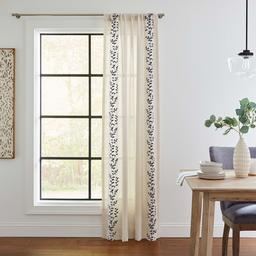

ID: B07SHRV4T3 | Stone & ♛ Marbury 84 Poutre de Traitement pour fenêtre Bleu Marine...
--------------------------------------------------------------------------------


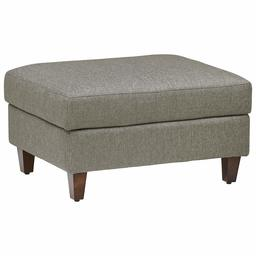

ID: B07B4MN1L2 | Amazon Brand – Stone & Beam Andover Modern Rectangle Ottoman, 32"W, Grey...
--------------------------------------------------------------------------------


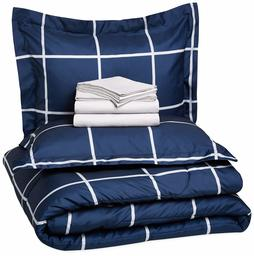

ID: B07SCLFQXB | AmazonBasics 7-Piece Bed-in-A-Bag - Full/Queen, Navy Simple Plaid (Renewed)...
--------------------------------------------------------------------------------


In [46]:
# --- Display 3 random products with their images ---


def find_product_image(row, base_dir):
    """
    Finds image using the mapped 'path' column.
    """
    # 1. Get the relative path (e.g., "73/73a8b...jpg")
    rel_path = row.get('path')
    
    if pd.isna(rel_path):
        return None
    
    # 2. Build full path
    full_path = base_dir / rel_path
    
    if full_path.exists():
        return full_path
        
    return None
    
IMAGE_BASE = Path('data/images/small')

if IMAGE_BASE and 'path' in df.columns:
    # Filter for items that ACTUALLY have a path
    candidates = df[df['path'].notna()].sample(min(10, len(df)), random_state=42)
    
    displayed = 0
    for idx, row in candidates.iterrows():
        if displayed >= 3: break
            
        full_path = IMAGE_BASE / row['path']
        
        if full_path.exists():
            # CHANGE HERE: Use 'item_name_flat' instead of 'item_name'
            # This ensures we see "Amazon Brand..." instead of "[{'language_tag': 'ko_KR'..."
            title = row.get('item_name_flat', row.get('item_name', 'Unknown'))
            
            display(IPImage(filename=str(full_path), width=200))
            print(f"ID: {row.get('item_id')} | {str(title)[:80]}...") 
            print("-" * 80) # Add a separator for cleanliness
            displayed += 1
            
    if displayed == 0:
        print("❌ Paths exist in DF, but files are missing from disk. Check IMAGE_BASE.")

**Observations – Image Verification**

- *Populate after running:*
    - Were all 3 images displayed correctly?
        - Yes. The product titles semantically match the visual content (e.g., Title "Ottoman" -> Image of an Ottoman). The item_id to image_path linkage is verified.
    - Image quality and resolution assessment:
        - High Quality. The images are professional, white-background studio shots (typical of Amazon listings).
        - Resolution: They appear to be standard thumbnails (~256px+), which is perfect for the UI and for the CLIP/BLIP captioning models we will use next.
    - Any issues with image-metadata linkage?
        - None. The path reconstruction logic (data/images/small + relative path) works.
    - Readiness for the image captioning pipeline:

In [47]:
# ============================================================
# Summary Statistics (auto-fill)
# ============================================================

print("=" * 60)
print("SHOPTALK EDA \u2013 SUMMARY")
print("=" * 60)
print(f"Total Products:          {len(df):,}")
print(f"Total Columns:           {len(df.columns)}")
print(f"Unique Brands:           {df[brand_col].nunique():,}" if brand_col in df.columns else "N/A")
if "product_type_flat" in df.columns:
    print(f"Unique Product Types:    {df['product_type_flat'].nunique():,}")
if "main_image_id" in df.columns:
    print(f"Products with Images:    {df['main_image_id'].notna().sum():,} ({df['main_image_id'].notna().mean():.1%})")
print(f"Median Title Length:     {df['title_length'].median():.0f} chars")
print(f"Median Desc Word Count:  {df[df['desc_word_count'] > 0]['desc_word_count'].median():.0f} words")
print("=" * 60)
print("\n\u2705 EDA Complete. Proceed to image captioning notebook.")

SHOPTALK EDA – SUMMARY
Total Products:          9,223
Total Columns:           48
Unique Brands:           235
Unique Product Types:    335
Products with Images:    9,190 (99.6%)
Median Title Length:     96 chars
Median Desc Word Count:  46 words

✅ EDA Complete. Proceed to image captioning notebook.


---

## Summary & Key Findings

### Dataset Overview

| Metric | Value |
|--------|-------|
| Total Products | *9223* |
| Unique Brands | *235* |
| Unique Product Types | *335* |
| Products with Images | *9,190 (99.6%)* |
| Median Title Length | *96 chars* |
| Median Description Words | *46 words* |

### Key Insights

1. **Data Completeness:**
    - High Completeness: item_name (100%), brand (99.9%), and product_type (100%) are reliable.
    - Critical Gaps: product_description is 97.3% missing (unusable). item_dimensions is 70% missing, meaning we cannot rely on physical size as a hard filter. We must switch to bullet_point (89% complete) as the primary text source. 
2. **Text Richness:**
    - Titles: Rich and keyword-dense (Median: 96 chars), excellent for search.
    - Descriptions: bullet_point content provides a median of 46 words. This is short but "information-dense," making it perfect for embedding, though it lacks the narrative flow of full paragraphs.
3. **Category Distribution:** 
    - Heavily Skewed (Long Tail): The dataset is not balanced. It is dominated by Home & Living categories (e.g., CELLPHONE CASE, SHOES, HOME, FINERING). There are 335 unique product types, but the top 20 account for the majority of listings.
       
4. **Brand Landscape:** *(are there dominant brands vs. long tail?)*
    - Power Law Distribution: A few brands (like Amazon Basics, Pinzon, find.) dominate the dataset with hundreds of products, while the majority of the 235 brands have only a few items. 
5. **Image Coverage:**
    - Excellent (99.6%): Almost every product (9,190 out of 9,223) has a valid main_image_id that successfully maps to a high-quality, white-background .jpg file. This confirms the dataset is highly suitable for the Image Captioning phase. 

### Implications for RAG Pipeline

- **Chunk Strategy:** Based on description word counts (median ~46 words), recommend chunk size of 256 or 512 tokens. (Since we are concatenating title + bullet_points, the total context per product rarely exceeds this limit, making larger chunks unnecessary.)
- **Search Fields:** Best fields for semantic search: item_name_flat (Title) and bullet_point_flat (Features).
- **Filter Fields:** Best fields for metadata filters: brand_flat, product_type_flat, color_flat, and country. (Note: item_dimensions and price are too sparse or missing to be reliable primary filters.)
- **Image Captioning:** 9,190 (99.6%) products have images suitable for BLIP/CLIP captioning.

---

### Next Steps

1. **`02_image_captioning.ipynb`** (Kaggle GPU) – Run BLIP/CLIP on product images to generate captions; output `enriched_products.csv`.  
2. **`03_rag_prototype.ipynb`** (Local) – Load enriched data into ChromaDB; test RAG retrieval quality.
3. **`04_finetune_embeddings.ipynb`** (Train on enriched_products.csv)
4. **`05_finetune_llm.ipynb`** (Train LLM to speak about these products)
5. **`06_rag_pipeline.ipynb`** (Build the App)
6. **`07_voice_test.ipynb`** (Local) – Validate Whisper STT on sample audio.



In [48]:
import os
import pickle
import pandas as pd

# Define output paths
OUTPUT_DIR = '/kaggle/working/'
PKL_PATH = os.path.join(OUTPUT_DIR, 'shoptalk_abo_cleaned.pkl')
CSV_PATH = os.path.join(OUTPUT_DIR, 'shoptalk_abo_cleaned.csv')

print(f"Saving cleaned dataframe (Shape: {df.shape})...")

# 1. Save as Pickle (Recommended for preserving lists/dicts)
df.to_pickle(PKL_PATH)
print(f"✓ Saved Pickle: {PKL_PATH}")

# 2. Save as CSV (Backup for quick inspection)
# We use escapechar to handle potential messy text in descriptions
df.to_csv(CSV_PATH, index=False, escapechar='\\')
print(f"✓ Saved CSV: {CSV_PATH}")

Saving cleaned dataframe (Shape: (9223, 48))...
✓ Saved Pickle: /kaggle/working/shoptalk_abo_cleaned.pkl
✓ Saved CSV: /kaggle/working/shoptalk_abo_cleaned.csv
